In [1]:
%matplotlib inline
from __future__ import division
import tensorflow as tf
import numpy as np
import h5py
import os
import six
from six.moves import range
import itertools
import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
from PIL import ImageOps
from PIL import ImageEnhance
import matplotlib.font_manager
from PIL import ImageDraw, ImageFont, ImageFilter

In [2]:
h5py.version.version

'2.7.0'

In [3]:
data_dir = '../data'
model_dir = '../data/model'
model_name = 'steering_mixture_prob'
os.makedirs(model_dir, exist_ok=True)
crop_size = (64, 48)

h5 = h5py.File(os.path.join(data_dir, 'train.hdf5'))

In [4]:
print("{:10}| {:10}| {:30}".format("name", "dtype", "shape"))
print("-" * 40)
for name, dset in h5.items():
    print("{:10}| {:10}| {:30}".format(name, str(dset.dtype), str(dset.shape)))

name      | dtype     | shape                         
----------------------------------------
image     | uint8     | (7180, 60, 80)                
speed     | float32   | (7180, 1)                     
steering  | float32   | (7180, 1)                     
timestamp | float64   | (7180, 1)                     


In [5]:
def data_generator(batch_size=128, n_epoch=-1):
    n = len(h5['image'])
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_batches = n // batch_size
    if n_epoch == -1:
        n_epoch = 1000000000
    for epoch in range(n_epoch):
        for b in range(0, n, batch_size):
            batch_idx = np.sort(idx[b:b+batch_size])
            yield {
                'image': h5['image'][batch_idx, :, :],
                'steering': h5['steering'][batch_idx, :],
                'speed': h5['speed'][batch_idx, :],
            }
    
batch = next(data_generator())

In [6]:
batch['image'].min(), batch['image'].max(), 

(16, 164)

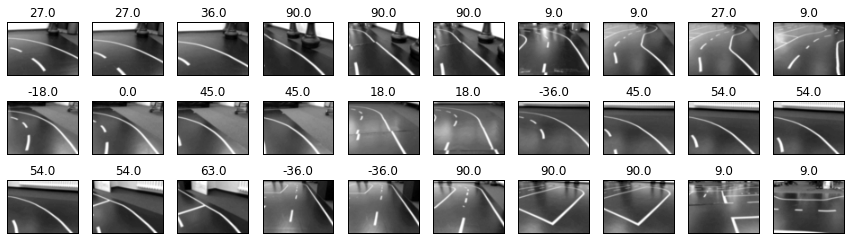

In [7]:
fig, axes = plt.subplots(3, 10, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    ax.set_title("{:.1f}".format(float(180 / np.pi * batch['steering'][i])))
    ax.imshow(batch['image'][i], cmap='gray')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

#### number of seconds per epoch

In [8]:
#%%timeit -n 3

#for batch in data_generator(n_epoch=1):
#    pass

In [9]:
batch = next(data_generator())

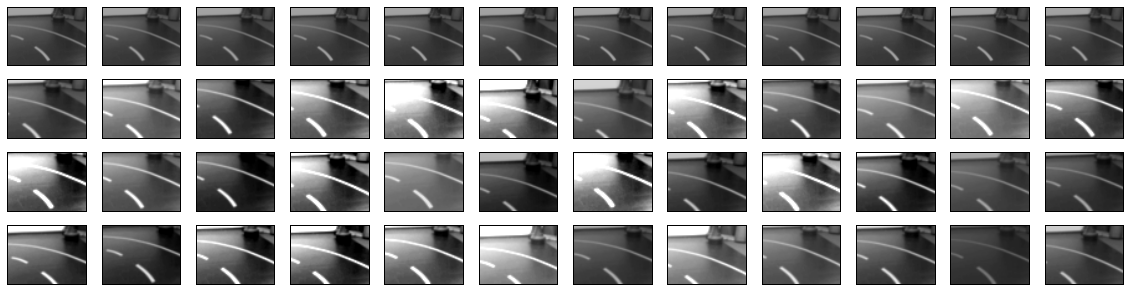

In [10]:
def augment_img(img):
    width, height = img.size
    max_crop_left = img.size[0] - crop_size[0]
    max_crop_upper = img.size[1] - crop_size[1]
    left = np.random.choice(max_crop_left)
    upper = np.random.choice(max_crop_upper)
    img = img.crop([left, upper, left + crop_size[0], upper + crop_size[1]])
                    #width - left, height - upper])
    brightness = ImageEnhance.Brightness(img)

    img = brightness.enhance(np.random.uniform(0.75, 2.5))
    contrast = ImageEnhance.Contrast(img)
    img = contrast.enhance(np.random.uniform(0.75, 2.5))
    return img

images = [PIL.Image.fromarray(x) for x in batch["image"]]
img = images[0]
fig, axes = plt.subplots(4, 12, figsize=(20, 5))

for ax in axes[:1].flat:
    ax.imshow(np.array(img), cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
for ax in axes[1:].flat:
    ax.imshow(np.array(augment_img(img)), cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])

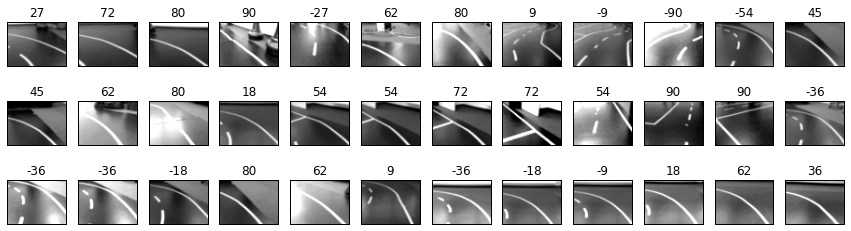

In [11]:
def augment_batch(batch):
    images = [PIL.Image.fromarray(x) for x in batch["image"]]
    images = [augment_img(img) for img in images]
    batch_aug = {'images': np.stack([np.array(img) for img in images])}
    for k, v in batch.items():
        if k != 'images':
            batch_aug[k] = v
    return batch_aug

batch_aug = augment_batch(batch)

fig, axes = plt.subplots(3, 12, figsize=(15, 4))

for ax, img, steering in zip(axes.flat, batch_aug['images'], batch_aug['steering']):
    ax.imshow((img), cmap='gray')
    ax.set_title("{:}".format(int(180*float(steering) / np.pi)))
    ax.set_xticks([])
    ax.set_yticks([])

In [12]:
def batch_to_numpy(batch):
    x = 2.* batch['images'] / 255. - 1 
    y = batch['steering']
    return x[:,:,:,np.newaxis], y

X, y = batch_to_numpy(batch_aug)
print("data: {}, labels: {}".format(X.shape, y.shape))
print("data max: {}, data min: {}".format(X.max(), X.min()))
print("labels max: {}, labels min: {}".format(y.max(), y.min()))

data: (128, 48, 64, 1), labels: (128, 1)
data max: 1.0, data min: -1.0
labels max: 1.5707963705062866, labels min: -1.5707963705062866


In [13]:
def labels_to_int(y, n_buckets=180):
    return (y / np.pi * n_buckets + n_buckets // 2).astype(np.int)

In [14]:
def log_p_x(x, pi_logits, means, s, delta = np.pi / (2*180), min=-np.pi/2, max=np.pi/2):
    """
    bs - batch_size
    w - width
    k - number of components
    
    x: (bs, w, 1)
    mu, s, pi_logits: (bs, w, k)
    """

    # rv = tf.contrib.distributions.Logistic(means, s)
    cdf = lambda t: tf.nn.sigmoid((t - means) / s)   
    p = cdf(x + delta) - cdf(x - delta)
    p_bar = p
    k = pi_logits.get_shape()[-1]
    x = tf.tile(x, [1, 1, int(k)])
    p = tf.where(
        x - delta <= min, 
        cdf(min),
        p,
    )
    p = tf.where(
        x + delta >= max,
        1. - cdf(max),
        p,
    )
    return tf.reduce_logsumexp(tf.nn.log_softmax(pi_logits) + tf.log(tf.maximum(p, 1e-12)), axis=-1)

def log_p_x_pdf(x, pi_logits, means, s):
    rv = tf.contrib.distributions.Logistic(means, s)
    p = rv.prob(x)
    return tf.reduce_logsumexp(tf.nn.log_softmax(pi_logits) + tf.log(tf.maximum(p, 1e-12)), axis=-1)

def discretize_mixture(pi_logits, means, s, min=-np.pi/2, max=np.pi/2, num=180):
    x = tf.linspace(min, max, num)
    x = tf.expand_dims(x, axis=0)
    bs = means.shape[0]
    x = tf.tile(x, [tf.shape(means)[0], 1])
    x = tf.expand_dims(x, axis=-1)
    
    pi_logits = tf.tile(pi_logits, [1, num, 1])
    means = tf.tile(means, [1, num, 1])
    s = tf.tile(s, [1, num, 1])
    return log_p_x(
        x, pi_logits, means, s, min=min, max=max
    )

In [15]:

n_mixtures = 6
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

x = tf.placeholder(tf.float32, shape=[None, crop_size[1], crop_size[0], 1])
y_true = tf.placeholder(tf.float32, shape=[None, 1])

f = 12
k = 3


# data images are 48x64

l = tf.layers.conv2d(x,f, 5, padding='same')
l = tf.layers.batch_normalization(l)
l = tf.nn.relu(l)
l = tf.layers.max_pooling2d(l, 2, 2)

# 24x32 after pooling
l = tf.layers.conv2d(x,2*f, k, padding='same')
l = tf.layers.batch_normalization(l)
l = tf.nn.relu(l)
l = tf.layers.max_pooling2d(l, 2, 2)

# 12x16
l = tf.layers.conv2d(x,4*f, k, padding='same')
l = tf.layers.batch_normalization(l)
l = tf.nn.relu(l)
l = tf.layers.max_pooling2d(l, (2,2), 2)

# 6x8
l = tf.layers.conv2d(x,8*f, k, padding='same')
l = tf.layers.batch_normalization(l)
l = tf.nn.relu(l)
l = tf.layers.average_pooling2d(l,(6,8),1)
l = tf.contrib.layers.flatten(l)

mu = np.pi * tf.tanh(tf.layers.dense(l, n_mixtures))
pi_logits = tf.layers.dense(l, n_mixtures)
s = tf.nn.softplus(tf.layers.dense(l, n_mixtures))

mu = tf.expand_dims(mu, axis=1)
pi_logits = tf.expand_dims(pi_logits, axis=1)
s = tf.expand_dims(s, axis=1)


loss = -log_p_x(tf.expand_dims(y_true, axis=1), pi_logits, mu, s)

discr_prob = discretize_mixture(pi_logits, mu, s)

opt = tf.train.AdamOptimizer(learning_rate=0.0003)
opt_op = opt.minimize(loss)

init_op = tf.global_variables_initializer()
sess.run(init_op)

history = []

(128, 180)


<Container object of 180 artists>

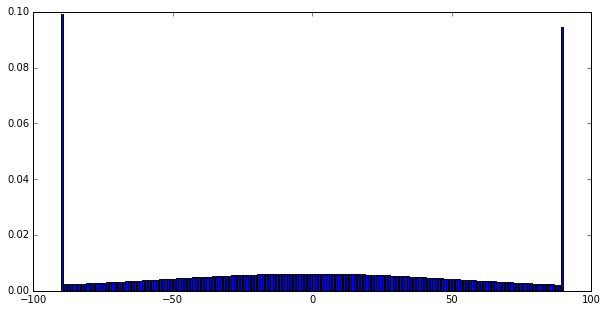

In [16]:
probs, = sess.run([discr_prob], feed_dict={x: X})
print(probs.shape)
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(np.arange(180) - 90, np.exp(probs[1]))

In [17]:
tqdm_gen = tqdm(data_generator(n_epoch=10))
running_loss = 'init'
for batch in tqdm_gen:
    X,y = batch_to_numpy(augment_batch(batch))
    y += np.random.normal(0, 0.005 * np.pi, y.shape)
    y = np.clip(y, -np.pi / 2, np.pi / 2)
    batch_loss = np.mean(sess.run([loss, opt_op], feed_dict={x:X, y_true: y})[0])
    
    history.append(batch_loss)
    if running_loss == 'init':
        running_loss = batch_loss
    else:
        running_loss = 0.9*running_loss + 0.1*batch_loss
    tqdm_gen.set_description('loss: {:.02f}'.format(running_loss))
    
    
saver = tf.train.Saver()
save_path = saver.save(sess, os.path.join(model_dir, model_name + ".ckpt"))

loss: 4.65: 57it [00:16,  3.92it/s]


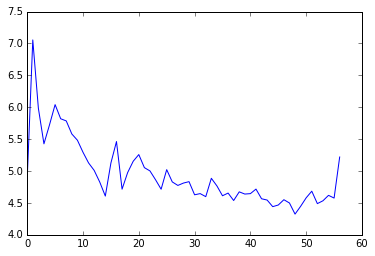

In [18]:
plt.plot(history)

(12, 180)


IndexError: index 30 is out of bounds for axis 0 with size 12

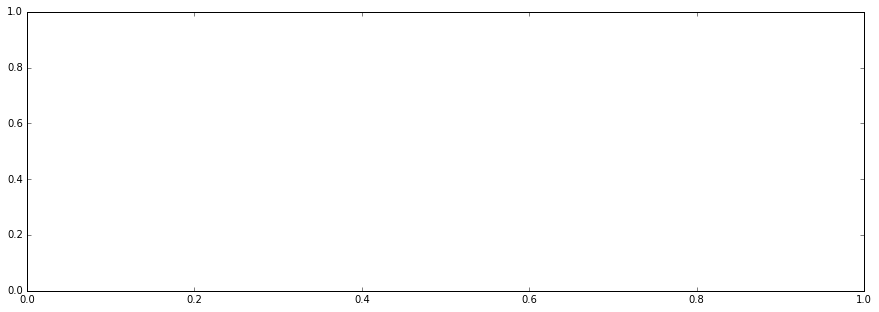

In [19]:
probs, = sess.run([discr_prob], feed_dict={x: X})
print(probs.shape)
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(180) - 90, np.exp(probs[30]))

In [ ]:
def image_draw_info(img, steering_true, steering_pred, font=None):
    if font is None:
        fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
        mono_fonts = [f for f in fonts if "mono" in f.lower() and 'bold' in f.lower()]
        mono_font = mono_fonts[0]
        font = ImageFont.truetype(mono_font, 18)

    draw = ImageDraw.Draw(img_scale)

    draw.text((10, 20), "steering_true: {}".format(steering_true), fill="#00ff00", font=font)
    angle = steering_true + np.pi/2
    x = 1/2 * img_scale.size[0]
    y = 100
    draw.line([x, y, x +  160*np.cos(angle), y  - 160*np.sin(angle)], fill="#00ff00", width=5)

    draw.text((400, 20), "steering_pred: {}".format(steering_pred), fill="#0000ff", font=font)
    angle = steering_pred + np.pi/2
    draw.line([x, y, x +  160*np.cos(angle), y  - 160*np.sin(angle)], fill="#0000ff", width=5)
    del draw

img = h5['image'][0]
img = PIL.Image.fromarray(img)
img_scale = img.resize((640,480))
img_scale = img_scale.convert("RGB")
image_draw_info(img_scale, 1.5, -1.5)

In [ ]:

plt.imshow(np.array(img_scale))